In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/01_PLOT_DIAGNOSTIC/'
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [3]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/1666 [00:00<?, ?it/s]

In [4]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

640


In [5]:
# 1) vmx, rmx, fcor, R34/R50/R64 + comparison with best-track data
# 2) B, rossby, Uc, R+, R0, eventually V+ and V0.
# By basin and by t(LMI)

(array([ 5.,  3.,  7.,  9.,  5.,  7., 11.,  9.,  8., 12., 16.,  6., 17.,
        11., 10., 19., 19., 16., 18., 10., 10., 21.,  7.,  8., 21., 12.,
        19., 12., 13.,  8.,  8., 17., 14.,  8.,  8., 10., 16.,  7., 11.,
         8.,  5.,  3.,  2.,  9.,  3.,  4.,  4.,  1.,  0.,  3.,  2.,  2.,
         2.,  3.,  2.,  4.,  4.,  4.,  2.,  2.,  3.,  2.,  1.,  2.,  2.,
         1.,  1.,  2.,  1.,  0.,  1.,  2.,  2.,  1.,  1.,  2.,  1.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 0.5095032 ,  0.75729401,  1.00508481,  1.25287562,  1.50066643,
         1.74845724,  1.99624805,  2.24403886,  2.49182966,  2.73962047,
         2.98741128,  3.23520209,  3.4829929 ,  3.7307837 ,  3.97857451,
         4.22636532,  4.47415613,  4.72194694,  4.96973775,  5.21752855,
         5.46531936,  5.71311017,  5.96090098,  6.20869179,  6.4564826 ,
         6.7042734 ,  6.95206421,  7.19985502,  7.44764583,  7.695436

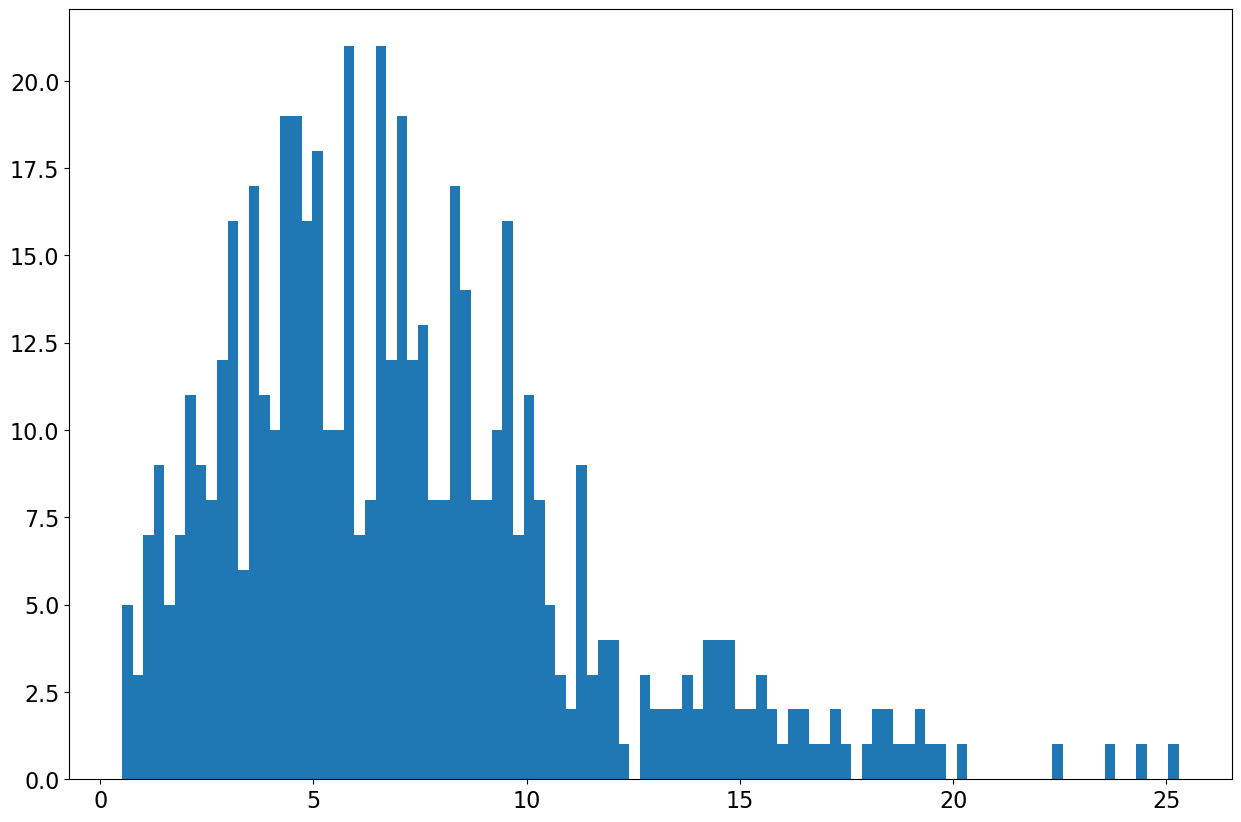

In [6]:
plt.hist(d.vws_pmd, bins=100)

### 1) By basin

/tmp/ipykernel_17155/3980428699.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_17155/3980428699.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


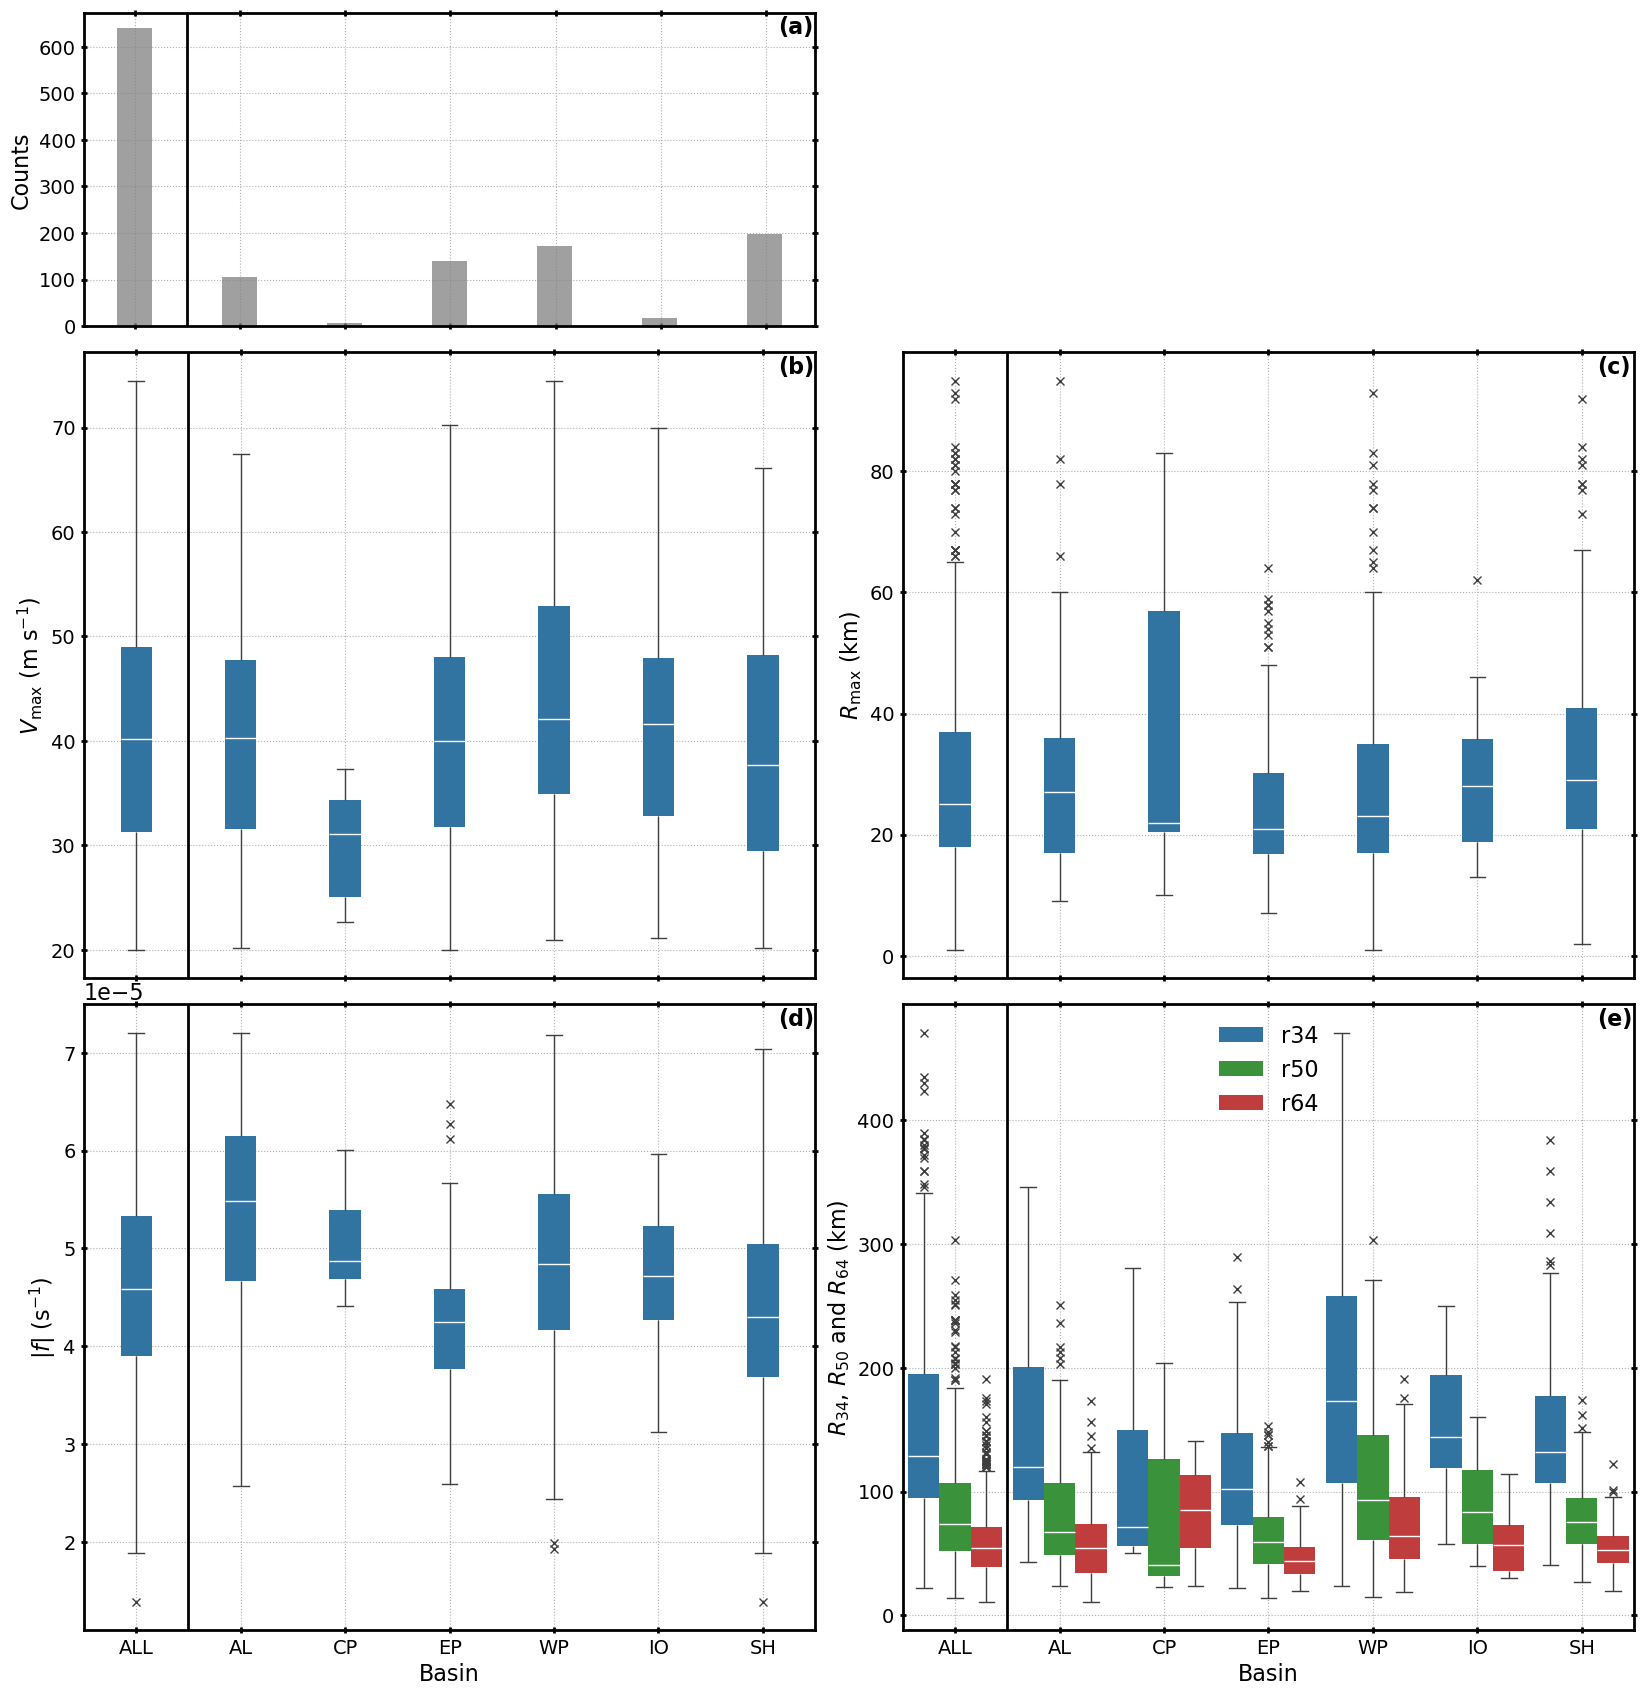

In [7]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 21))
gs         = GridSpec(3, 2, hspace=0.05, wspace=0.12, height_ratios=[1, 2, 2])

##############
### COUNTS ###
##############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.935, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])

# Boxplot
g = sns.histplot(
    data=df_combined,
    x='basin_idx',
    bins=bins,
    color='grey',
    edgecolor=None,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'Counts')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### VMAX ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'vmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### RMAX ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$R_{\text{max}}$ (km)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### FCOR ###
############
ax = fig.add_subplot(gs[2, 0])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'fcor']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'fcor': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[2, 1])
ax.text(0.95, 0.965, '(e)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r34': color_glob, 
    'r50': 'tab:green',
    'r64': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'best_track_prms_by_basin.png', bbox_inches='tight')

/tmp/ipykernel_17155/4093062280.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_17155/4093062280.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


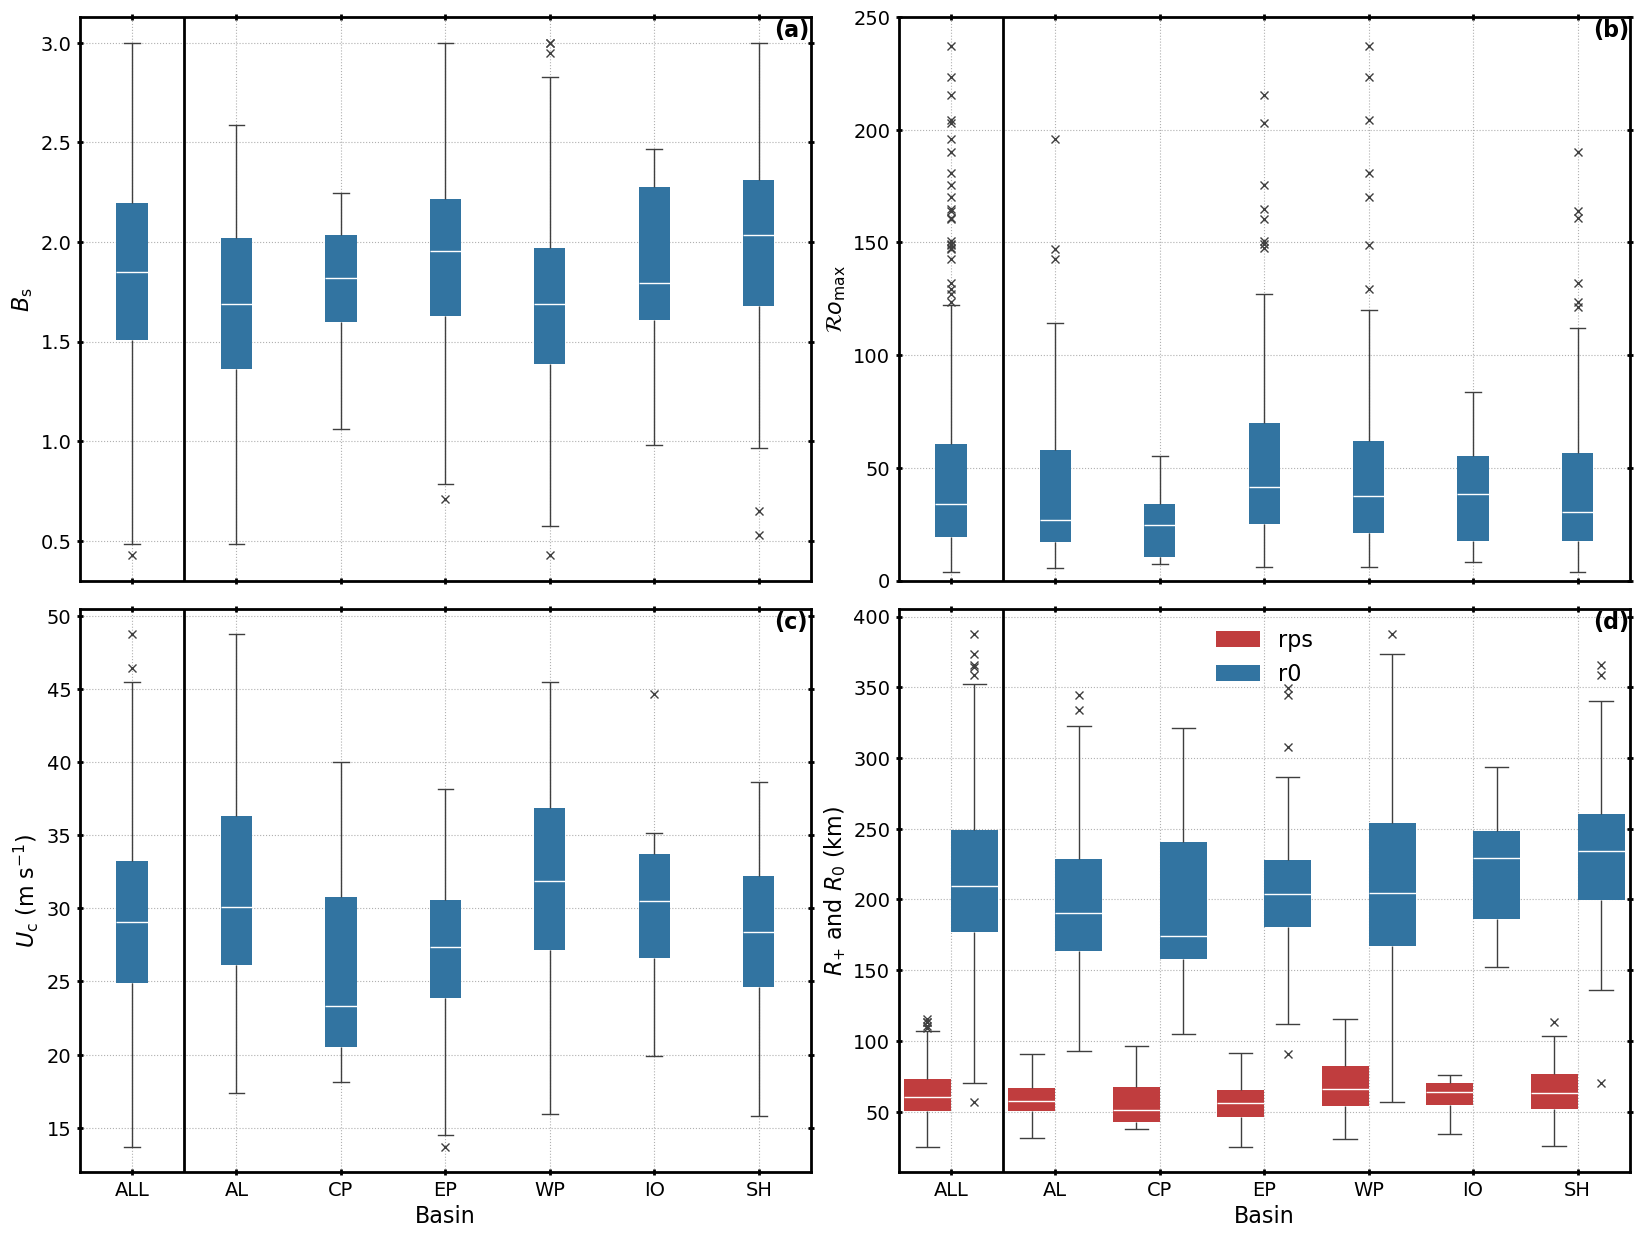

In [8]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 15))
gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12, height_ratios=[2, 2])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['B_hol'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'B_hol': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$B_{\text{s}}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rsby ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rsby']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rsby'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rsby': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

ax.set_ylim(0, 250)

############
###  Uc  ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'uc']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['uc'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'uc': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rps', 'r0']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rps', 'r0'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r0':  color_glob, 
    'rps': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{\text{+}}$ and $R_{\text{0}}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'dynamical_prms_by_basin.png', bbox_inches='tight')

### 2) By time

In [9]:
# Choose time reference
nb_of_days  = 3
delta_t     = 1 # 1 for 12 hours, 2 for 24 hours, etc...
tLMI_bins   = np.linspace(-24 * nb_of_days - delta_t * 6, 24 * nb_of_days + delta_t * 6, int(4 / delta_t) * nb_of_days + 2)
tLMI_labels = np.linspace(-24 * nb_of_days, 24 * nb_of_days, int(4 / delta_t) * nb_of_days + 1)
print(tLMI_bins)
print(tLMI_labels)

# Initialize
l_tLMI_labels = []

# Assign label iteratively
for t in tqdm(range(len(d.time))):
    notInAnyBin = True
    for k in range(len(tLMI_bins) - 1):
        if (d.isel(time=t).t_since_lmi_ibt / 3600 >= tLMI_bins[k]) and (d.isel(time=t).t_since_lmi_ibt / 3600 <= tLMI_bins[k + 1]):
            l_tLMI_labels.append(float(tLMI_labels[k]))
            notInAnyBin = False
    if notInAnyBin:
        l_tLMI_labels.append(np.nan)

# Assign output list
d['tLMI_lab'] = xr.DataArray(l_tLMI_labels, d.coords)

# Choose basin
db         = d.where(d.basin == 'ep', drop=True).dropna(dim='time', subset=['tLMI_lab']) # d_basin
print(len(db.time))

[-78. -66. -54. -42. -30. -18.  -6.   6.  18.  30.  42.  54.  66.  78.]
[-72. -60. -48. -36. -24. -12.   0.  12.  24.  36.  48.  60.  72.]


  0%|          | 0/640 [00:00<?, ?it/s]

120


/tmp/ipykernel_17155/1245637467.py:194: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_17155/1245637467.py:249: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


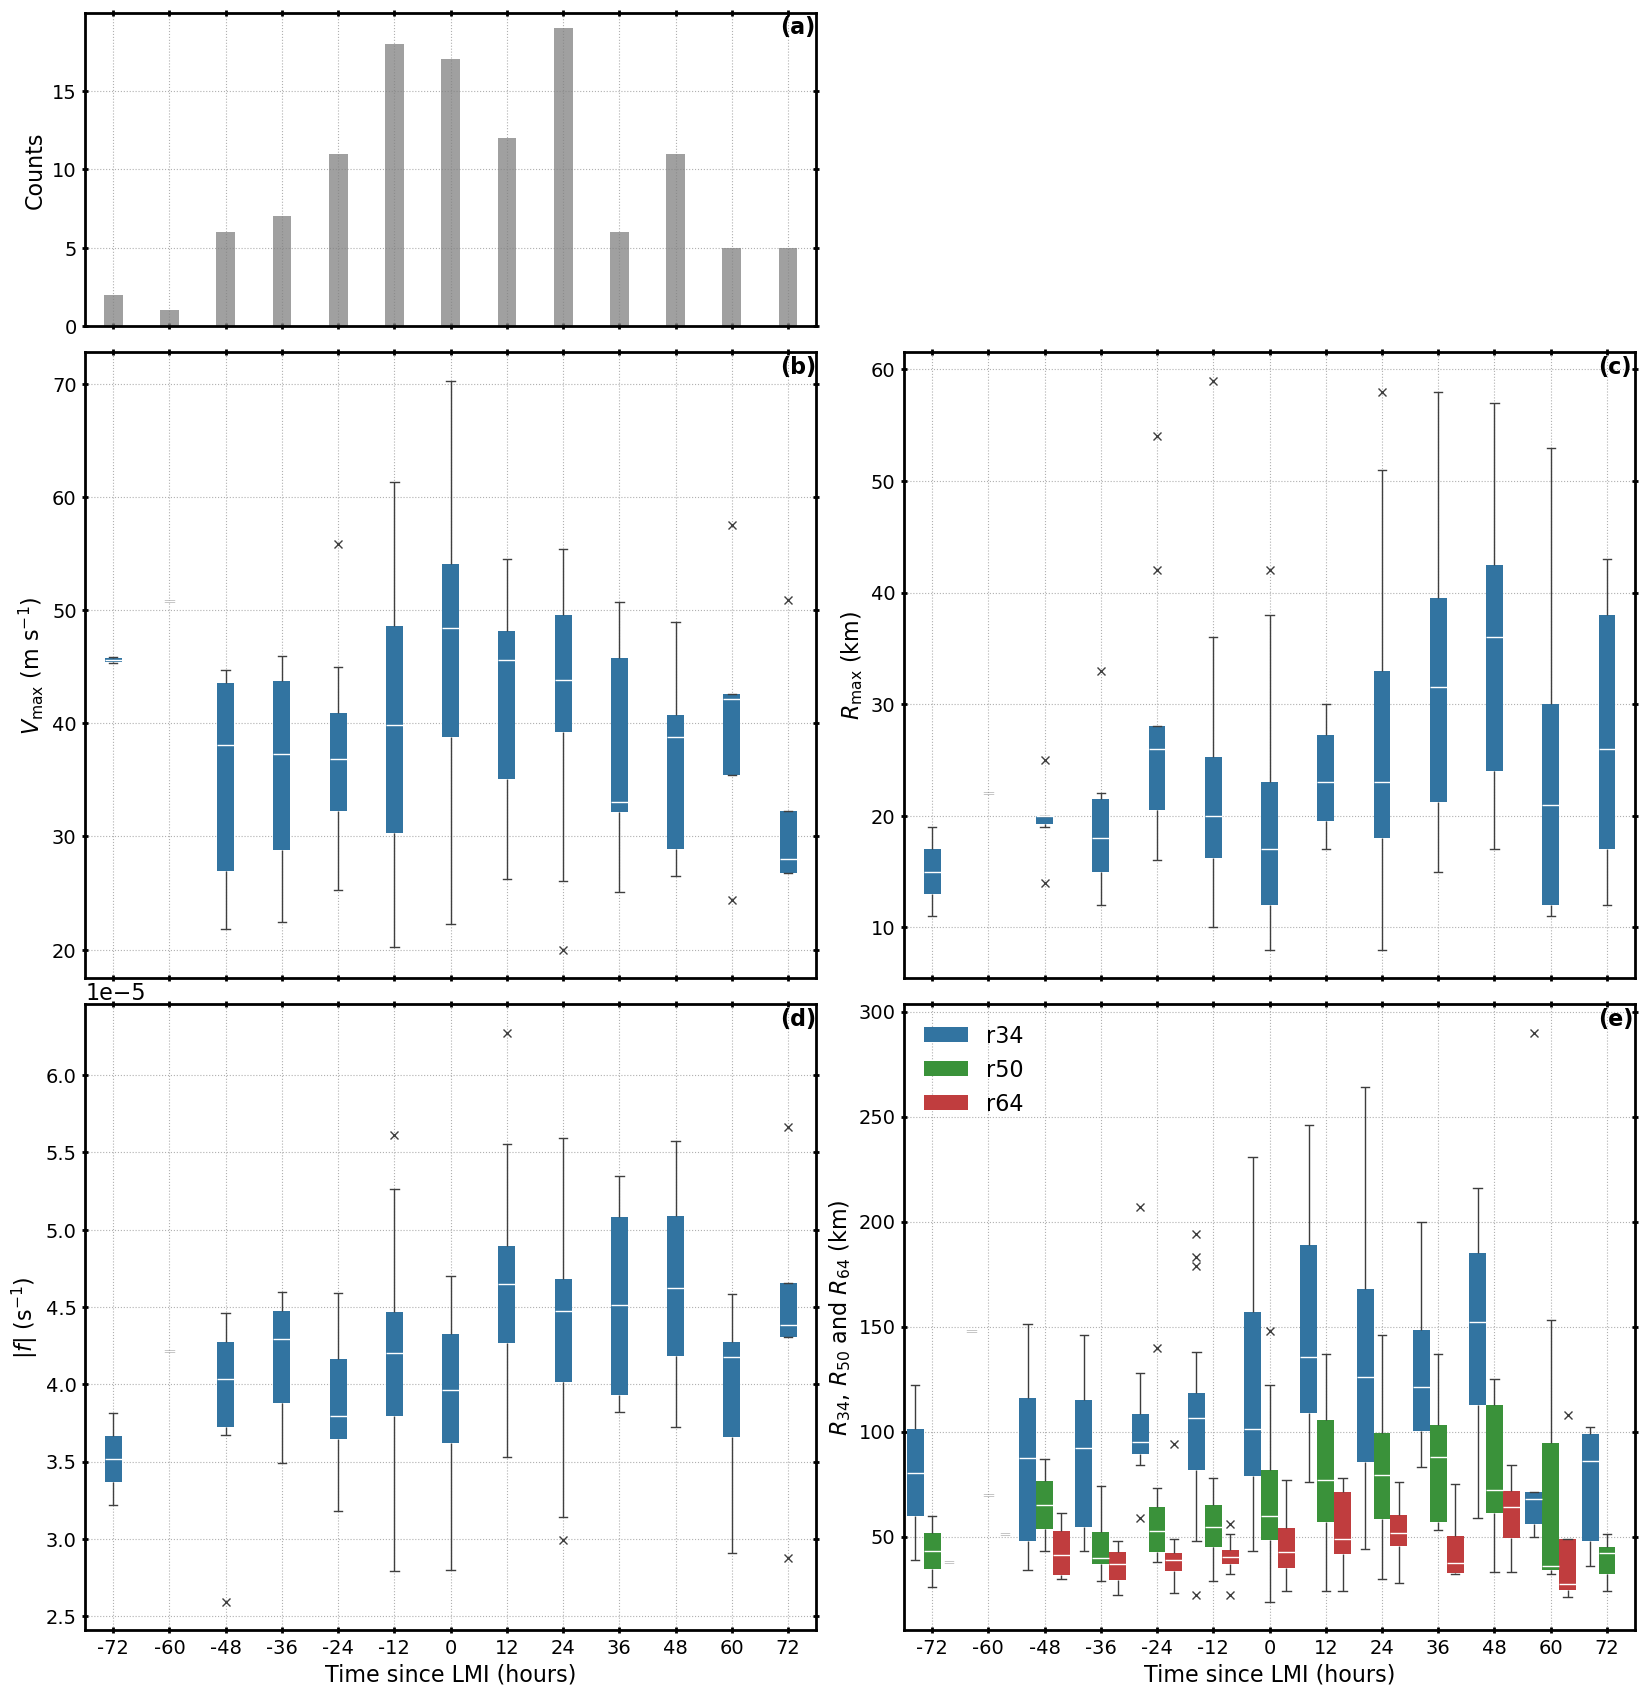

In [10]:
# Hyperparameters
width      = 0.3
width_bis  = 4
bins       = np.arange(-24 * nb_of_days - width_bis / 2, 24 * nb_of_days + width_bis / 2 + (tLMI_bins[1] - tLMI_bins[0]), width_bis)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 21))
gs         = GridSpec(3, 2, hspace=0.05, wspace=0.12, height_ratios=[1, 2, 2])

##############
### COUNTS ###
##############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.935, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['vmx'])
df_global              = df_plot.copy()
# df_global['tLMI_lab']  = 0
df_combined            = pd.concat([df_plot, df_global])

# Boxplot
g = sns.histplot(
    data=df_plot,
    x='tLMI_lab',
    bins=bins,
    color='grey',
    edgecolor=None,
)

# Labels
# xlabels = [int(l) for l in tLMI_labels]
ax.set_xticks(tLMI_labels)
ax.set_xlim(-24 * nb_of_days - 6, 24 * nb_of_days + 6)
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'Counts')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### VMAX ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['vmx'])
# Colors
palette                = {'vmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# Test
boxplot_xlim = plt.xlim()

############
### RMAX ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'rmx']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['rmx'])
df_plot['value']       = df_plot['value'] / 1000
# Colors
palette                = {'rmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$R_{\text{max}}$ (km)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### FCOR ###
############
ax = fig.add_subplot(gs[2, 0])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'fcor']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['fcor'])
df_plot['value']       = abs(df_plot['value'])
# Colors
palette                = {'fcor': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
xlabels = [int(l) for l in tLMI_labels]
g.set_xticklabels(xlabels)
g.set_xlabel('Time since LMI (hours)')
g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[2, 1])
ax.text(0.95, 0.965, '(e)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'r34', 'r50', 'r64']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['r34', 'r50', 'r64'])
df_plot['value']       = df_plot['value'] / 1000
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r34': color_glob, 
    'r50': 'tab:green',
    'r64': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Labels
xlabels = [int(l) for l in tLMI_labels]
g.set_xticklabels(xlabels)
g.set_xlabel('Time since LMI (hours)')
g.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
ax.legend(frameon=False, loc='upper left')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'best_track_prms_by_time_for_one_basin.png', bbox_inches='tight')

/tmp/ipykernel_17155/1293838059.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_17155/1293838059.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


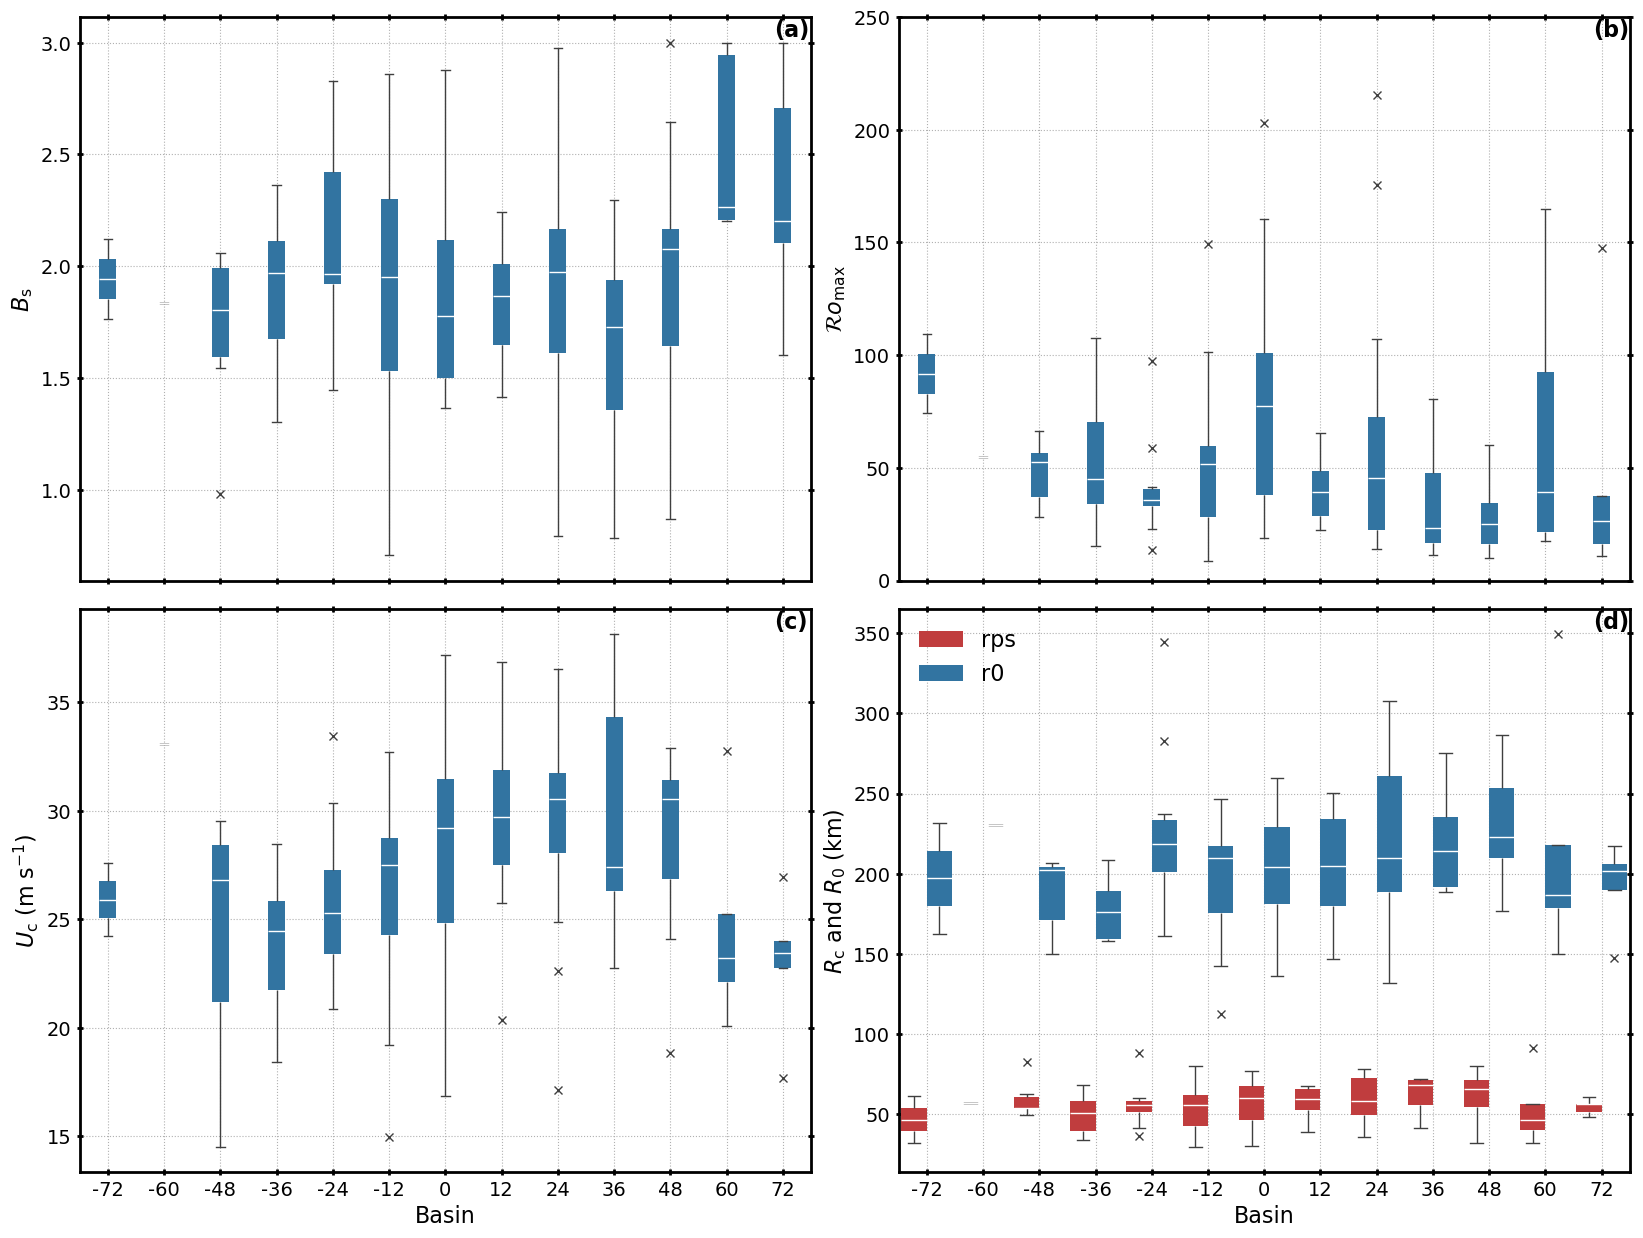

In [11]:
# Hyperparameters
width      = 0.3
# bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
bins='auto'
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 15))
gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12, height_ratios=[2, 2])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'B_hol']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['B_hol'])
# Colors
palette                = {'B_hol': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$B_{\text{s}}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rsby ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'rsby']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['rsby'])
# Colors
palette                = {'rsby': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

ax.set_ylim(0, 250)

############
###  Uc  ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'uc']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['uc'])
df_plot['value']       = abs(df_plot['value'])
# Colors
palette                = {'uc': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
xlabels = [int(l) for l in tLMI_labels]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'rps', 'r0']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['rps', 'r0'])
df_plot['value']       = df_plot['value'] / 1000
# Colors
palette = {
    'r0':  color_glob, 
    'rps': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Labels
xlabels = [int(l) for l in tLMI_labels]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{\text{c}}$ and $R_{\text{0}}$ (km)')
ax.legend(frameon=False, loc='upper left')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'dynamical_prms_by_time_for_one_basin.png', bbox_inches='tight')

#### Wind profile evolution

In [12]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### REFERENCE GRID
rs = np.linspace(0, 500000, 50001) # define dr accordingly

In [13]:
# [-78. -66. -54. -42. -30. -18.  -6.   6.  18.  30.  42.  54.  66.  78.]
# [-72. -60. -48. -36. -24. -12.   0.  12.  24.  36.  48.  60.  72.]

In [14]:
initializing = db.where(db.tLMI_lab <= -24, drop=True) # play with it, change 24 to 36 and vice versa :)
intensifying = db.where((db.tLMI_lab > -24) & (db.tLMI_lab <= 0),  drop=True) # same here
____maturing = db.where((db.tLMI_lab > 0)   & (db.tLMI_lab <= 24), drop=True)
___weakening = db.where(db.tLMI_lab  > 24,  drop=True)
print('Intializing = {}\nIntensifying = {}\nMaturing = {}\nWeakening = {}'.format(len(initializing.time), len(intensifying.time), len(____maturing.time), len(___weakening.time)))

# With the mean
V_initializing = holland_profile(rs, float(initializing.lat.mean(dim='time', skipna=True)), float(initializing.B_hol.mean(dim='time', skipna=True)), float(initializing.vmn_hol.mean(dim='time', skipna=True)), float(initializing.rmx_hol.mean(dim='time', skipna=True)), float(initializing.vmx_hol.mean(dim='time', skipna=True)))
V_intensifying = holland_profile(rs, float(intensifying.lat.mean(dim='time', skipna=True)), float(intensifying.B_hol.mean(dim='time', skipna=True)), float(intensifying.vmn_hol.mean(dim='time', skipna=True)), float(intensifying.rmx_hol.mean(dim='time', skipna=True)), float(intensifying.vmx_hol.mean(dim='time', skipna=True)))
V_____maturing = holland_profile(rs, float(____maturing.lat.mean(dim='time', skipna=True)), float(____maturing.B_hol.mean(dim='time', skipna=True)), float(____maturing.vmn_hol.mean(dim='time', skipna=True)), float(____maturing.rmx_hol.mean(dim='time', skipna=True)), float(____maturing.vmx_hol.mean(dim='time', skipna=True)))
V____weakening = holland_profile(rs, float(___weakening.lat.mean(dim='time', skipna=True)), float(___weakening.B_hol.mean(dim='time', skipna=True)), float(___weakening.vmn_hol.mean(dim='time', skipna=True)), float(___weakening.rmx_hol.mean(dim='time', skipna=True)), float(___weakening.vmx_hol.mean(dim='time', skipna=True)))
lVs            = [V_initializing, V_intensifying, V_____maturing, V____weakening]

Intializing = 27
Intensifying = 35
Maturing = 31
Weakening = 27


In [15]:
# # With the median
# V_initializing = holland_profile(rs, float(initializing.lat.median(dim='time', skipna=True)), float(initializing.B_hol.median(dim='time', skipna=True)), float(initializing.vmn_hol.median(dim='time', skipna=True)), float(initializing.rmx_hol.median(dim='time', skipna=True)), float(initializing.vmx_hol.median(dim='time', skipna=True)))
# V_intensifying = holland_profile(rs, float(intensifying.lat.median(dim='time', skipna=True)), float(intensifying.B_hol.median(dim='time', skipna=True)), float(intensifying.vmn_hol.median(dim='time', skipna=True)), float(intensifying.rmx_hol.median(dim='time', skipna=True)), float(intensifying.vmx_hol.median(dim='time', skipna=True)))
# V_____maturing = holland_profile(rs, float(____maturing.lat.median(dim='time', skipna=True)), float(____maturing.B_hol.median(dim='time', skipna=True)), float(____maturing.vmn_hol.median(dim='time', skipna=True)), float(____maturing.rmx_hol.median(dim='time', skipna=True)), float(____maturing.vmx_hol.median(dim='time', skipna=True)))
# V____weakening = holland_profile(rs, float(___weakening.lat.median(dim='time', skipna=True)), float(___weakening.B_hol.median(dim='time', skipna=True)), float(___weakening.vmn_hol.median(dim='time', skipna=True)), float(___weakening.rmx_hol.median(dim='time', skipna=True)), float(___weakening.vmx_hol.median(dim='time', skipna=True)))
# lVs            = [V_initializing, V_intensifying, V_____maturing, V____weakening]

In [16]:
from matplotlib.colors import LinearSegmentedColormap
# colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered'), mpl.colors.to_rgb('royalblue')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)

In [17]:
# cm = plt.get_cmap('Reds')

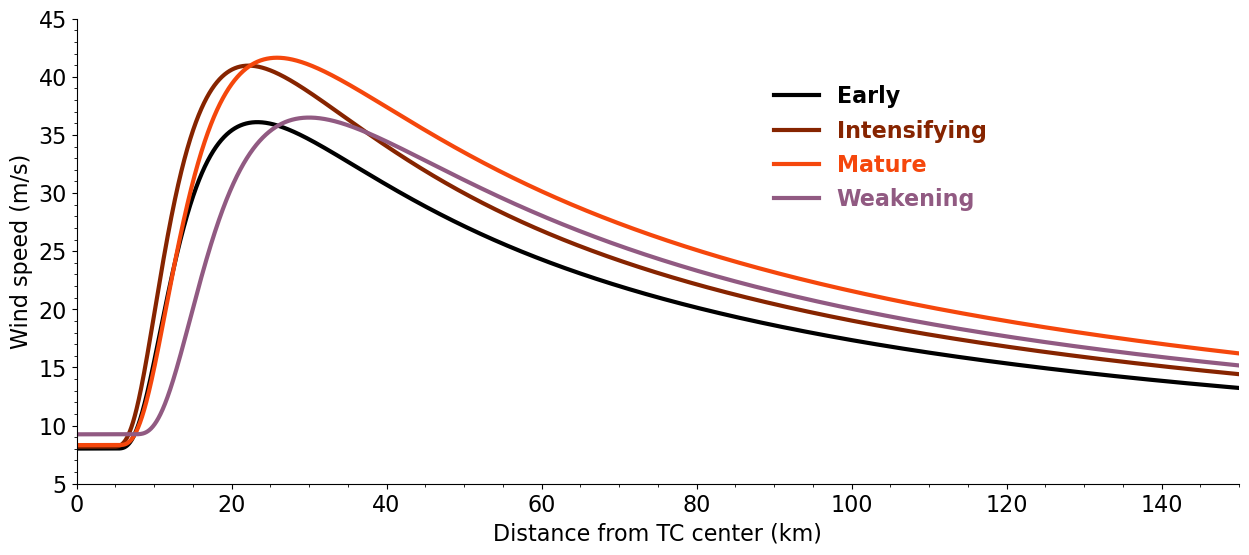

In [19]:
fig        = plt.figure(figsize=(15, 10))
gs         = GridSpec(1, 1, hspace=0.18, wspace=0.02)

normalizer = Normalize(0, 80)
ax_lims2D  = 250

labels     = ['Early', 'Intensifying', 'Mature', 'Weakening']

############
# PROFILES #
############
ax = fig.add_subplot(gs[0, 0])
# ax.set_title('d', weight='bold', loc='left')

for k, Vh in enumerate(lVs):
    ax.plot(rs / 1000, Vh, c=cm(k / len(lVs)), linewidth=3, label=labels[k])

ax.set_xlim(0, 150);ax.set_ylim(5, 45)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.8, 0.9), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'wind_profile_evolution.png', bbox_inches='tight')

In [129]:
### With (V*, r*) and real data (not Holland)

# Reference grid
r_star = np.linspace(0, 8, 150)

# Instantiate list
VSTARS = []

for t in tqdm(range(len(d.time))):
    # Open wind speed
    ws = xr.open_dataset(PTHS['sar_dir'] + d.isel(time=t).file_tcva.item()).isel(time=0).wind_speed.mean(dim='theta')

    # Interpolate and append
    # VSTARS.append(np.interp(r_star, np.array(ws.rad) / float(d.isel(time=t).rmx), np.array(ws)))
    VSTARS.append(np.interp(r_star, np.array(ws.rad) / float(d.isel(time=t).rmx), np.array(ws) / float(d.isel(time=t).vmx)))
    # VSTARS.append(np.interp(r_star, np.array(ws.rad) / float(d.isel(time=t).r34), np.array(ws)))
    # VSTARS.append(np.interp(r_star, np.array(ws.rad) / float(d.isel(time=t).r34), np.array(ws) / float(d.isel(time=t).vmx)))

    # Close dataset
    ws.close()

  0%|          | 0/640 [00:00<?, ?it/s]

In [130]:
# Concatenate into a single dataset
dstar = xr.Dataset(
    data_vars={
        'v_star':       (('time', 'r_star'), VSTARS),
    },
    coords={
        'r_star': r_star,
        'time':   np.array(d.time)
    }
)

# Ancillary information
dstar['tLMI_lab'] = d.tLMI_lab.copy(deep=True)
dstar['basin']    = d.basin.copy(deep=True)

In [131]:
# Choose basin
dbstar         = dstar.where(d.basin == 'ep', drop=True).dropna(dim='time', subset=['tLMI_lab']) # d_basin
print(len(dbstar.time))

# Separate phase
initializing = dbstar.where(dbstar.tLMI_lab <= -24, drop=True) # play with it, change 24 to 36 and vice versa :)
intensifying = dbstar.where((dbstar.tLMI_lab > -24) & (dbstar.tLMI_lab <= 0),  drop=True) # same here
____maturing = dbstar.where((dbstar.tLMI_lab > 0)   & (dbstar.tLMI_lab <= 24), drop=True)
___weakening = dbstar.where(dbstar.tLMI_lab  > 24,  drop=True)
print('Intializing = {}\nIntensifying = {}\nMaturing = {}\nWeakening = {}'.format(len(initializing.time), len(intensifying.time), len(____maturing.time), len(___weakening.time)))

# With the mean
V_initializing = np.array(initializing.v_star.mean(dim='time', skipna=True))
V_intensifying = np.array(intensifying.v_star.mean(dim='time', skipna=True))
V_____maturing = np.array(____maturing.v_star.mean(dim='time', skipna=True))
V____weakening = np.array(___weakening.v_star.mean(dim='time', skipna=True))
lVs            = [V_initializing, V_intensifying, V_____maturing, V____weakening]

120
Intializing = 27
Intensifying = 35
Maturing = 31
Weakening = 27


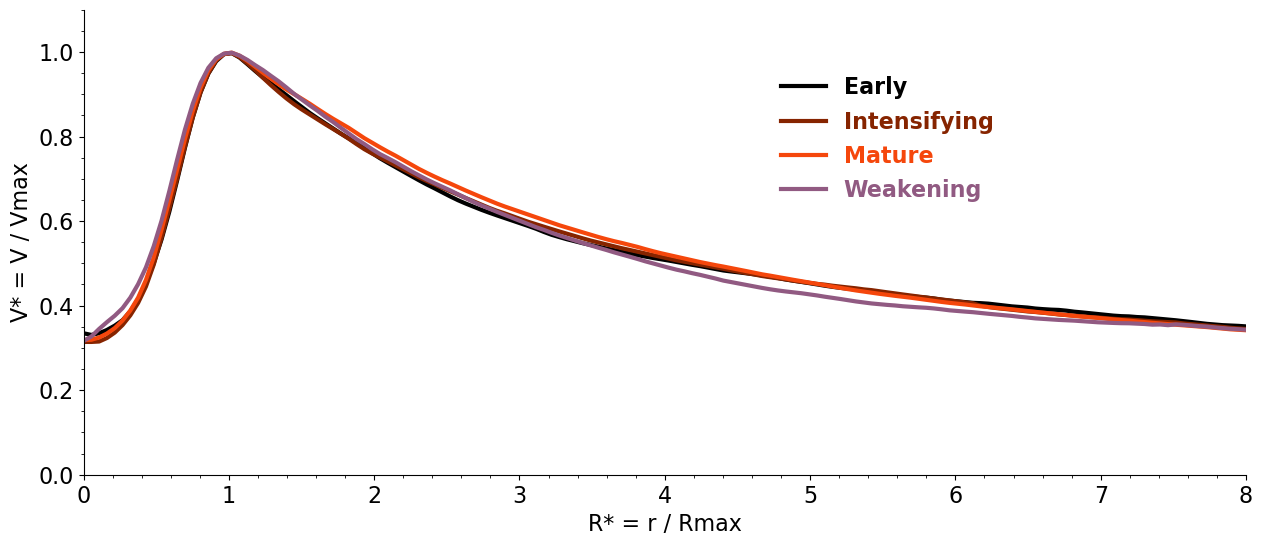

In [132]:
fig        = plt.figure(figsize=(15, 10))
gs         = GridSpec(1, 1, hspace=0.18, wspace=0.02)

normalizer = Normalize(0, 80)
ax_lims2D  = 250

labels     = ['Early', 'Intensifying', 'Mature', 'Weakening']

############
# PROFILES #
############
ax = fig.add_subplot(gs[0, 0])
# ax.set_title('d', weight='bold', loc='left')

for k, Vh in enumerate(lVs):
    ax.plot(r_star, Vh, c=cm(k / len(lVs)), linewidth=3, label=labels[k])

ax.set_xlim(0, 8);ax.set_ylim(0, 1.1)
# ax.set_xlim(0, 8);ax.set_ylim(5, 50)
ax.set_xlabel('R* = r / Rmax')
ax.set_ylabel('V* = V / Vmax')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.8, 0.9), prop=dict(weight='bold'))

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

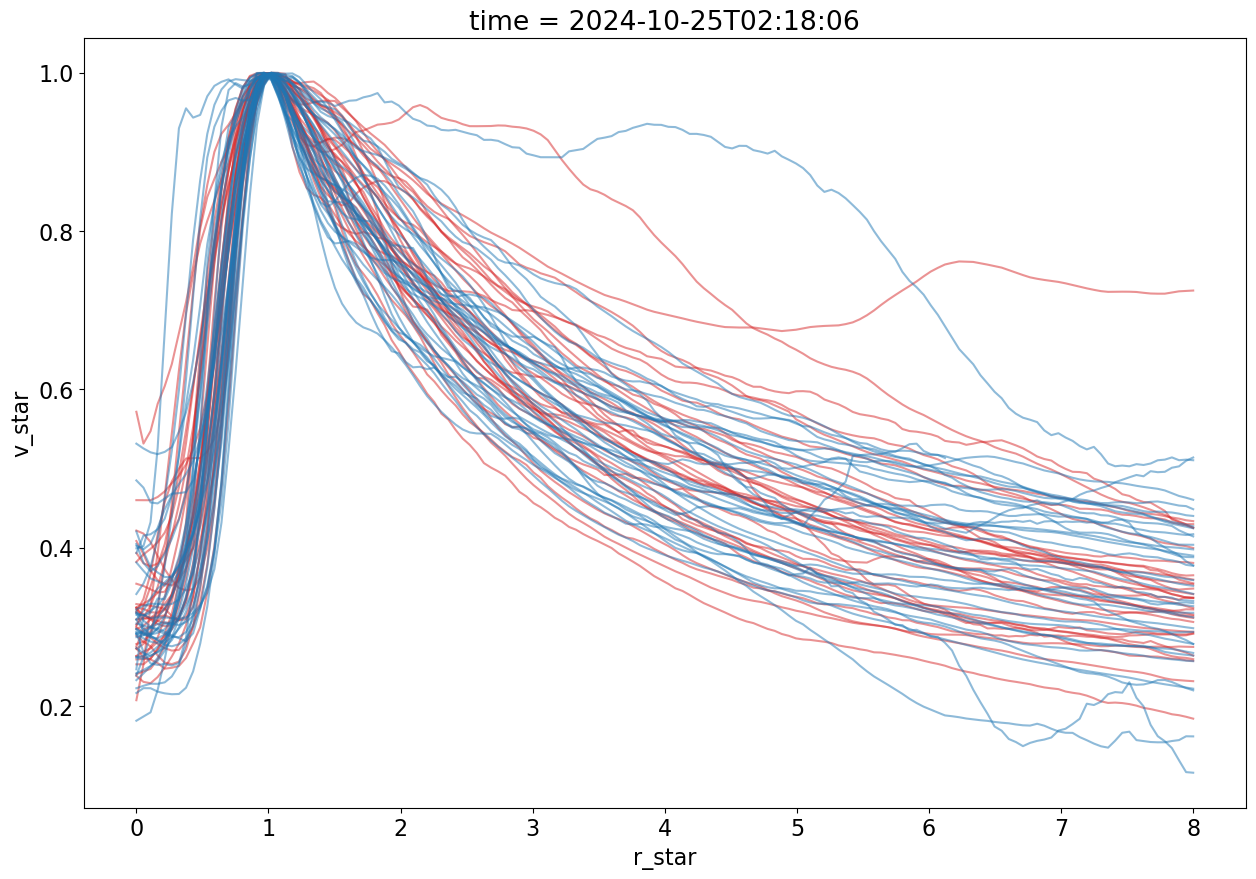

In [133]:
for t in tqdm(range(len(____maturing.time))):
    ____maturing.isel(time=t).v_star.plot(c='tab:red', alpha=0.5)

for t in tqdm(range(len(intensifying.time))):
    intensifying.isel(time=t).v_star.plot(c='tab:blue', alpha=0.5)

In [12]:
# # Hyperparameters
# width = 0.3

# fig        = plt.figure(figsize=(20, 20))
# gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12)

# ############
# ### VMAX ###
# ############
# ax = fig.add_subplot(gs[0, 0])

# # Data pre.
# df                     = d[['basin_idx', 'vmx']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# # xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# # g.set_xticklabels(xlabels)
# # g.set_xlabel('Basin')
# ax.set_xticklabels([])
# ax.set_xlabel('')
# g.set_ylabel(r'$V_{max}$ (m s$^{-1}$)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### RMAX ###
# ############
# ax = fig.add_subplot(gs[0, 1])

# # Data pre.
# df                     = d[['basin_idx', 'rmx']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
# df_plot['value']       = df_plot['value'] / 1000
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# # xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# # g.set_xticklabels(xlabels)
# # g.set_xlabel('Basin')
# ax.set_xticklabels([])
# ax.set_xlabel('')
# g.set_ylabel(r'$R_{max}$ (km)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### FCOR ###
# ############
# ax = fig.add_subplot(gs[1, 0])

# # Data pre.
# df                     = d[['basin_idx', 'fcor']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
# df_plot['value']       = abs(df_plot['value'])
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
# g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### Rxx  ###
# ############
# ax = fig.add_subplot(gs[1, 1])

# # Data pre.
# df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
# df_plot['value']       = df_plot['value'] / 1000
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},], dtype='datetime64[ns]')
#     flierprops=dict(marker='x', color='grey'),
#     width=width * 3,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
# g.set_ylabel(r'$R_{34}$, $R_{50}$ and $R_{64}$ (km)')
# ax.legend(frameon=False, loc='upper center')
# # ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background